In [1]:
# !pip install d2l
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn
from d2l import torch as d2l

In [2]:
with open('TRD_Dalyr.txt','r') as f:
    datas = f.readlines()
datas = [data.strip().split('\t') for data in datas]
datas = np.array(datas)
datas = datas[1:,2].astype(np.float)
print(datas)

[11.29 11.47 11.16 ... 22.48 22.53 22.26]


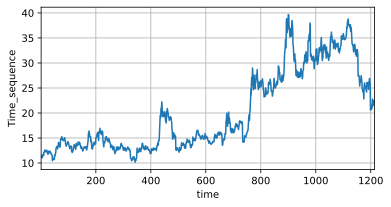

In [3]:
Time_sequence = torch.tensor(datas,dtype=torch.float32)
T = len(Time_sequence)
time = torch.arange(1,T+1,dtype = torch.float32)
d2l.plot(time, [Time_sequence], 'time', 'Time_sequence', xlim=[1, T], figsize=(6, 3))
# plt.savefig('data.svg')

In [4]:
tau = 30  # 用前30天的值预测今天的值
batch_size, n_train = 16, T-tau   # 只有前n_train个样本用于训练
epochs = 5   # 学习的轮数
lr = 0.01   # 学习率

In [5]:
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = Time_sequence[i: T - tau + i]
labels = Time_sequence[tau:].reshape((-1, 1))

In [6]:
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [7]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(30, 50),
                        nn.ReLU(),
                        nn.Linear(50, 1))
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

In [8]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, epochs, lr)
onestep_preds = net(features)

epoch 1, loss: 3.791762
epoch 2, loss: 2.135222
epoch 3, loss: 4.387587
epoch 4, loss: 1.480436
epoch 5, loss: 1.301062


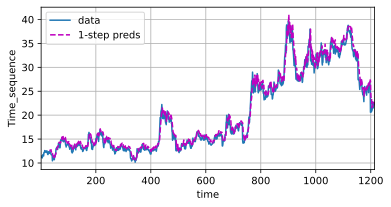

In [9]:
d2l.plot([time, time[tau:]],
         [Time_sequence.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'Time_sequence', legend=['data', '1-step preds'], xlim=[1, T],
         figsize=(6, 3))
# plt.savefig('data_1.svg')

In [10]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train ] = Time_sequence[: n_train ]
for i in range(n_train , T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

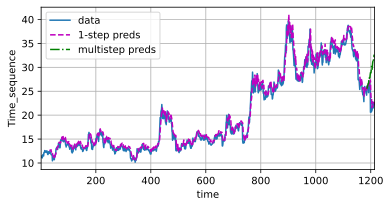

In [11]:
d2l.plot([time, time[tau:], time[n_train :]],
         [Time_sequence.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train :].detach().numpy()], 'time',
         'Time_sequence', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, T], figsize=(6, 3))
# plt.savefig('data_m.svg')

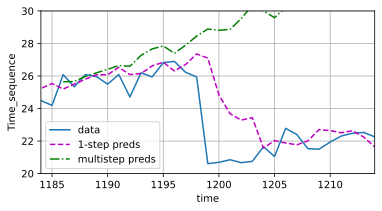

In [12]:
d2l.plot([time, time[tau:], time[n_train + 1:]],
         [Time_sequence.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + 1:].detach().numpy()], 'time',
         'Time_sequence', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[T-30, T], ylim=[20,30],figsize=(6, 3))
# plt.savefig('data_30.svg')

In [13]:
max_steps = 64

In [14]:
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i+1）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = Time_sequence[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i+1）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

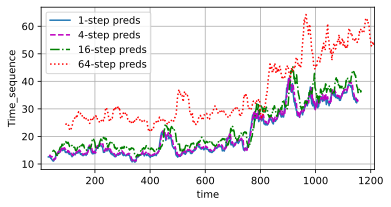

In [15]:
steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'Time_sequence',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, T],
         figsize=(6, 3))
# plt.savefig('data_mm.svg')